# Downstream Analysis - R

**Note**: This tutorial was originally written using R Markdown. If you would like to run or edit the R Markdown document, it can be found [here](https://github.com/morriso1/clonedetective/blob/master/rcode/rmd/downstream_analysis_R.Rmd)

## Recap - background and experimental aims

Our original demo dataset consisted of 67 images of the Drosophila intestine from a MARCM genetic cell lineage experiment. GFP (C1 channel) marks genetic recombination events, and so clusters of GFP positive cells define "clones" of daughter cells that over time have grown out from a single parent cell. The remaining images include DAPI (C0 channel), which ubiquitously marks all cell nuclei; PDM1 (C2 channel), which labels EnteroCyte (EC) cells; and Prospero (C3 channel), which labels EnteroEndocrine cells.

We aimed to investigate: 1) Does gene of interest regulate cell proliferation? 2) Does our gene of interest control cell differentiation? 3) Does gene of interest effect local tissue cell arrangement and structure?

We will tackle each of these experimental aims using data previously generated by clonedetective.

## Loading in data and libraries

Now we wrangle our data and plot results! Below, we do this using R tidyverse, cowplot and emmeans packages.

In [ ]:
#all_slow
#hide_output

knitr::opts_chunk$set(echo = TRUE)
# stats
library(MASS)
library(emmeans)
library(lme4)
library(glmmTMB)

# tidying up stat outputs
library(broom.mixed)

# data wrangling
library(tidyverse)

# ehlp with plotting
library(cowplot)
library(ggpubr)


In [ ]:
# hide_output
# absolute path to data
path_to_data <- "/Users/ottomorris/Documents/my_python_packages/clonedetective/data/example_results.csv"

count_df <- read_csv(path_to_data)



── Column specification ──────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  int_img = col_character(),
  seg_ch = col_character(),
  int_img_ch = col_character(),
  seg_img = col_character(),
  GFP_clonepos = col_logical(),
  EC_pos = col_logical(),
  EE_pos = col_logical(),
  ECEE_pos = col_logical(),
  ISCorEB_pos = col_logical(),
  preEC_pos = col_logical()
)
ℹ Use `spec()` for the full column specifications.




In [ ]:
count_df %>% head()



int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,⋯,centroid-1,eccentricity,area_um2,GFP_clonepos,total_intensity,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.55212,0.4408815,73.28063,FALSE,2196457,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.55212,0.4408815,73.28063,FALSE,52757,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.55212,0.4408815,73.28063,FALSE,2262648,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.55212,0.4408815,73.28063,FALSE,67331,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,12,0,4,0,4,1,3,4,0,⋯,486.79847,0.4652274,98.69063,FALSE,4113516,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,12,0,4,0,4,1,3,4,0,⋯,486.79847,0.4652274,98.69063,FALSE,99772,TRUE,FALSE,FALSE,FALSE,FALSE


## **Cell Proliferation - number of cells per clone**

Our first aim is to determine whether there is a difference in the number of cells per clone in mutant vs control animals. `count_df` currently contains four rows for each cell - one for each of the four intensity image channels. Since we are presently interested in cell types and numbers, rather than the intensity values of individual cells, we can query count_df for a single intensity image channel. This ensures that `count_data` contains only a single row for each cell.

For simplicity, we also filter out columns not required for counting the number and type of cells per clone.


In [ ]:
count_df <- count_df %>%
  pivot_wider(
    names_from = int_img_ch,
    values_from = c("total_intensity", "mean_intensity")
  ) %>%
  dplyr::select(matches("clone$|_pos$|int_img"))


Next, we groupby clones per image and sum to get the number of cells of each type per clone.



In [ ]:
count_df <- count_df %>%
  group_by(int_img, GFP_clone) %>%
  summarise(
    EC = sum(EC_pos),
    ECEE = sum(ECEE_pos),
    preEC = sum(preEC_pos),
    EE = sum(EE_pos),
    ISCorEB = sum(ISCorEB_pos)
  )


`summarise()` has grouped output by 'int_img'. You can override using the `.groups` argument.



To ease downstream wrangling and plotting, we update some of the column metadata.

For example, when plotting, it will be helpful to label whether a cell is inside a clone (IC) or outside a clone (OC). This information is present within the GFP_clone column: 0 indicates if a cell is outside a clone, and \>0 indicate if a cell is inside a clone.

We also can extract metadata stored within the image names. We know that images are named 'a1' if from a wild-type (ctrl) animal, and 'a2' if from a mutant (mut) animal. The 'a\\dg\\d\\d' pattern of the image name identifies the gut (animal) from which an image is taken (e.g. 'a1g01' is ctrl animal gut 1) . Using this information, we can add 'genotype' and 'gut' columns.


In [ ]:
count_df <- count_df %>% mutate(
  clone_status = as.factor(if_else(GFP_clone == 0, "OC", "IC")),
  genotype = as.factor(if_else(str_detect(int_img, "a1"), "ctrl", "mut")),
  gut = as_factor(str_extract(int_img, "g\\d\\d")),
  total = EC + ECEE + preEC + EE + ISCorEB
)


In [ ]:
count_df_tidy <-
  count_df %>%
  pivot_longer(cols = EC:ISCorEB, names_to = "cell_type", values_to = "cell_num") %>%
  mutate(cell_type = factor(cell_type, levels = c("ECEE", "EE", "EC", "preEC", "ISCorEB")))


We next generate a bar plot displaying cell numbers and types per clone. Here, we are only interested in plotting cells inside clones, and so we first filter on 'clone_status':



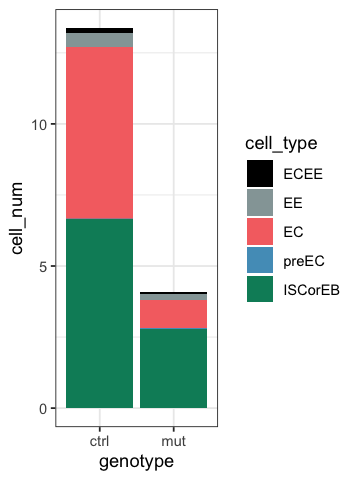

In [ ]:
# colors for our bar plot
col_pal <- c("#000000", "#95a5a6", "#F57171", "#539DC2", "#008b68")

stacked_bar_mean <- count_df_tidy %>%
  filter(clone_status == "IC") %>%
  ggplot(aes(fill = cell_type, y = cell_num, x = genotype)) +
  geom_bar(
    position = "stack",
    stat = "summary",
    fun = "mean"
  ) +
  theme_bw() +
  scale_fill_manual(values = col_pal)

options(repr.plot.width = 3, repr.plot.height = 4)
stacked_bar_mean


From this plot we can see that 'mutant' clones are on average bigger than 'ctrl' clones. This suggests that mutation of our gene of interest may affect cell proliferation. Since we have count data, let's fit a negative binomial regression using the 'MASS' package to test if this difference is significant.



In [ ]:
m1 <- glm.nb(total ~ genotype * clone_status, count_df)
glance(m1)


null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<logLik>,<dbl>,<dbl>,<dbl>,<int>,<int>
1849.033,495,-1723.41,3456.821,3477.854,518.8748,492,496


However, this simple model ignores the fact that each clone is 'nested' inside a gut. Errors may, therefore, correlate within guts, and so we should try to take account of this using a mixed-effect model:



In [ ]:
m2 <- glmer.nb(total ~ genotype * clone_status + (1 | gut), count_df)
glance(m2)


sigma,logLik,AIC,BIC,deviance,df.residual
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1715.031,3442.062,3467.301,500.5485,490


This model shows shows an improved (note the improved AIC score). However, the current negative binomial distribution does not account for the fact that clone cannot contain 0 cells! We, therefore, adjust our model to use a truncated negative binomial distribution.



In [ ]:
m3 <- glmmTMB(total ~ genotype * clone_status + (1 | gut), count_df, family = "truncated_nbinom2")
glance(m3)


sigma,logLik,AIC,BIC,df.residual
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.608627,-1630.508,3273.017,3298.256,490


This further improves the fit of our model.

We next move to test our desired contrast - do mutant clones possess fewer cells than control clones?


In [ ]:
em_m3 <- emmeans(m3, ~ genotype * clone_status)

contrast(em_m3, "pairwise", by = "clone_status", adjust = "fdr") %>% tidy()


clone_status,term,contrast,null.value,estimate,std.error,df,statistic,p.value
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IC,genotype,ctrl - mut,0,1.55072248,0.1372035,490,11.3023514,1.760469e-26
OC,genotype,ctrl - mut,0,0.09263063,0.3181798,490,0.2911267,7.710776e-01


From this we see that the total number of cells per clone is significantly different in "ctrl" vs "mutant" animals.

**Conclusion**:\
These data are consistent with a role for our gene of interest in controlling cell proliferation. However, complementary studies are be required to test this hypothesis further and eliminate alternative theories, e.g. does our gene of interest enhance cell death, leading to few cells per clone.

## Cell Differentiation - percentage cell type inside and outside clones

Next, let's investigate whether the types of cells inside and outside clones are different in ctrl and mutant animals. This information will help us determine whether our gene of interest affects cell differentiation.

First, since we already know that 'mutant' clones possess fewer cells than 'ctrl' clones, it is helpful to summarise cell types as proportions and percentages. We also create a composite


In [ ]:
prop_df_tidy <- count_df_tidy %>% mutate(
  pro_cell_num = cell_num / total,
  perc_cell_num = pro_cell_num * 100,
  genotype_clone_status = interaction(genotype, clone_status, sep = "\n")
)


In [ ]:
prop_df_tidy %>% head()



int_img,GFP_clone,clone_status,genotype,gut,total,cell_type,cell_num,pro_cell_num,perc_cell_num,genotype_clone_status
<chr>,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>
a1g01p1,0,OC,ctrl,g01,175,EC,70,0.400000000,40.0000000,ctrl OC
a1g01p1,0,OC,ctrl,g01,175,ECEE,4,0.022857143,2.2857143,ctrl OC
a1g01p1,0,OC,ctrl,g01,175,preEC,1,0.005714286,0.5714286,ctrl OC
a1g01p1,0,OC,ctrl,g01,175,EE,2,0.011428571,1.1428571,ctrl OC
a1g01p1,0,OC,ctrl,g01,175,ISCorEB,98,0.560000000,56.0000000,ctrl OC
a1g01p1,1,IC,ctrl,g01,14,EC,9,0.642857143,64.2857143,ctrl IC


Next, we plot a stacked barplot as before. However, this time we plot percentage cell types:



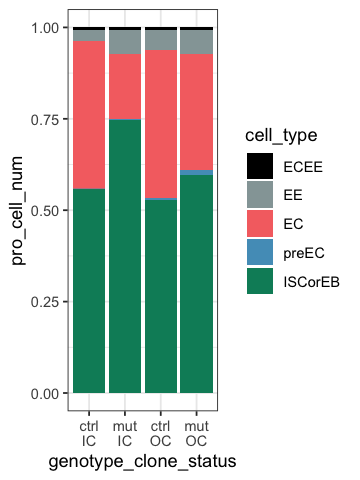

In [ ]:
stacked_bar_prop <- prop_df_tidy %>%
  ggplot(aes(fill = cell_type, y = pro_cell_num, x = genotype_clone_status)) +
  geom_bar(
    position = "fill",
    stat = "summary",
    fun = "mean"
  ) +
  theme_bw() +
  scale_fill_manual(values = col_pal)

options(repr.plot.width = 3, repr.plot.height = 4)
stacked_bar_prop


This plot suggests there might be a difference in percentage cell-types of mutant clones vs ctrl. Let's investigate if these differences are statistically significant. Since we have proportional data, we construct a quasibinomal regression model:



In [ ]:
ml_qb <- glm(pro_cell_num ~ genotype * clone_status * cell_type, family = quasibinomial(), prop_df_tidy)



Unfortunately, quasibinomal regression models do not currently support mixed-effects (via lme4 package). We, therefore, move onto our desired contrasts.

We wish to compare:  
* the percentage of each cell type inside mutant vs ctrl clones  
* the percentage of each cell type outside mutant vs ctrl clones  
* the percentage of each cell type outside mutant vs inside mutant clones

To do this, we setup pairwise contrasts by cell type and adjust for multiple comparisons using Benjamini/Hochberg false-discovery rate procedure:


In [ ]:
e_ml <- emmeans(ml_qb, ~ genotype * clone_status * cell_type)

comp_results <- contrast(e_ml, "pairwise",
  by = c("cell_type"),
  adjust = "fdr"
)

stat_results <- comp_results %>% tidy()
stat_results %>% head()


cell_type,term,contrast,null.value,estimate,std.error,df,z.ratio,adj.p.value
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ECEE,genotype*clone_status,ctrl IC - mut IC,0,0.02604153,0.741427,Inf,0.03512353,0.9719812
ECEE,genotype*clone_status,ctrl IC - ctrl OC,0,-0.34499874,1.227151,Inf,-0.28113790,0.9719812
ECEE,genotype*clone_status,ctrl IC - mut OC,0,-0.12599085,1.357413,Inf,-0.09281688,0.9719812
ECEE,genotype*clone_status,mut IC - ctrl OC,0,-0.37104027,1.209524,Inf,-0.30676542,0.9719812
ECEE,genotype*clone_status,mut IC - mut OC,0,-0.15203239,1.341499,Inf,-0.11333023,0.9719812
ECEE,genotype*clone_status,ctrl OC - mut OC,0,0.21900788,1.660062,Inf,0.13192753,0.9719812


To aid visualization, let's add these results to our stacked percentage barplot from earlier. We annotations only statistically significant comparisons:



In [ ]:
stat_anots <- stat_results %>%
  mutate(
    p = case_when(
      adj.p.value < 0.0001 ~ "****",
      adj.p.value < 0.001 ~ "***",
      adj.p.value < 0.01 ~ "**",
      adj.p.value < 0.05 ~ "*",
      adj.p.value < 1 ~ "ns"
    ),
  ) %>%
  filter(p != "ns", contrast != "mut IC - ctrl OC") %>%
  select(cell_type, contrast, p) %>%
  mutate(contrast = str_replace_all(contrast, "\ ", "\n"),
         y.position = c(1.05, 1.10, 1.15, 1.20, 1.25), 
         color = case_when(cell_type == 'EE' ~ "#95a5a6",
                           cell_type == 'EC' ~ "#F57171",
                           cell_type == 'ISCorEB' ~ "#008b68")) %>% 
  separate(contrast, sep = "\n-\n", c("group1", "group2"))


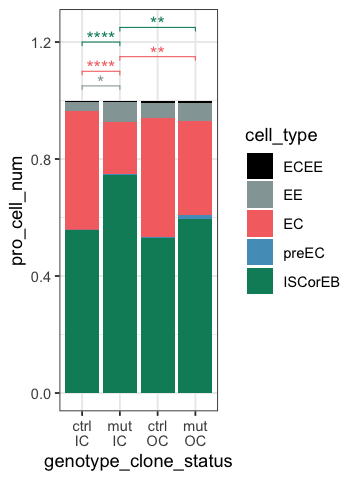

In [ ]:
options(repr.plot.width = 3, repr.plot.height = 4)
stacked_bar_prop + stat_pvalue_manual(stat_anots, color = rep(stat_anots$color, each=3), tip.length=0.01)


**Summary of results**:  
- comparing the percentage makeup of control and mutant clones, mutant clones possess significantly fewer ECs and significantly more progenitor cells (e.g. ISCs or EBs) and EEs.  
- comparing the percentage makeup of cells inside mutant clones and outside mutant clones, cells inside clones similarly possess significantly fewer ECs and more progenitor cells.  
- no significant difference is seen in the percentage makeup of cells outside clones in control vs mutant animals, suggesting our gene of interest may be haploinsufficient.

**Conclusion**:  
Together, these data suggest mutation of our gene of interest may hinder ISC -> EC differentiation. However, complementary studies are be required to further test this hypothesis and eliminate alternative theories, e.g. does our gene of interest lead to enhanced EC cell death, resulting in higher percentage progenitor and EE cells.
